In [68]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
style.use('ggplot')
import matplotlib
import datetime
matplotlib.rc('axes',edgecolor='darkgrey')

In [23]:
import os, sys
sys.path.append('../')
from ethpred.pipeline.generate_data import generate_data
from ethpred.pipeline.generate_data import sliding_window
from ethpred.utils.config_reader import read_config
from ethpred.pipeline.to_pandas import convert_to_dataframe
from ethpred.pipeline.data_reader import read_data
from ethpred.pipeline.normalizers import read_data

In [51]:
config_path = '/home/pjp18/Documents/marble_2020/config/config-broken.yaml'
cnf = read_config(config_path)
cnf['data']['sample_freq'] = cnf['data']['y_len']
cnf['data']['train_prop'] = 1

model_path = '/home/pjp18/Documents/marble_logs/model_2020-01-27T10_33_25.943376/model.pickle'
model = torch.load(model_path)

eth_price, gas_price = read_data(cnf)
data, normalizers = convert_to_dataframe(eth_price, gas_price, cnf)
data_array = data.to_numpy()

X, _y, indices = sliding_window(data_array, cnf['data'], return_indices=True)

timestamps = [v.to_pydatetime() for v in data.iloc[indices].index.tolist()]

X = torch.from_numpy(X).float()

with torch.no_grad():
    normalized_predictions = model(X).numpy()
# FIXME: only works when predicting a single series

normalizer = normalizers[cnf['data']['y_cols'][0]]

predictions = normalizer.inverse_transform(normalized_predictions)

truth = normalizer.inverse_transform(_y)


before resampling: 
                      average_gas_price  tx_count  max_price_tx  min_price_tx  \
time                                                                           
2019-11-20 00:00:03       5.852822e+09        85   26000000000    1000000000   
2019-11-20 00:00:25       1.746755e+10       227   60000000000    2000000000   
2019-11-20 00:00:35       1.240788e+10        61   30000000000    7380600900   
2019-11-20 00:00:38       2.258333e+10        12   40000000000   10000000000   
2019-11-20 00:00:39       6.155043e+09       176   60000000000    1200000000   

                       value  average_gas_price_lagged  
time                                                    
2019-11-20 00:00:03  176.038              2.000294e+10  
2019-11-20 00:00:25  176.038              2.355825e+10  
2019-11-20 00:00:35  176.038              2.355825e+10  
2019-11-20 00:00:38  176.038              2.355825e+10  
2019-11-20 00:00:39  176.038              2.355825e+10  
Empty DataFrame
Col

/home/pjp18/Documents/marble_2020/ethpred/pipeline/fft_truncation.py:46: RuntimeWarning: divide by zero encountered in true_divide
  sum_energy = sum_energy / max_cum[:, None, :]
/home/pjp18/Documents/marble_2020/ethpred/pipeline/fft_truncation.py:46: RuntimeWarning: invalid value encountered in true_divide
  sum_energy = sum_energy / max_cum[:, None, :]
/home/pjp18/Documents/marble_2020/ethpred/pipeline/fft_truncation.py:48: RuntimeWarning: invalid value encountered in greater_equal
  k_thresh = np.argmax(sum_energy >= energy, axis=1)
/home/pjp18/Documents/marble_2020/ethpred/pipeline/fft_truncation.py:53: RuntimeWarning: invalid value encountered in greater_equal
  k_filter = sum_energy >= energy


In [59]:
for col in cnf['data']['y_cols']:
    idx = data.columns.get_loc(col)
    print(cnf['data']['y_cols'], idx)

print(predictions.shape)
print(truth[:,:,idx].shape)

print(len(timestamps))

['min_price_tx'] 3
(75, 12)
(75, 12)
75


In [62]:
truth = truth[:,:,idx]

In [63]:
y_pred = np.concatenate(predictions)
y_true = np.concatenate(truth)
print(y_pred.shape)
print(y_true.shape)

(900,)
(900,)


In [76]:
print(len(timestamps))
all_stamps = []
for i in timestamps:
    cur_stamps = []
    j = 1
    while j <= 12:
        cur_stamps.append(i+datetime.timedelta(minutes=5*j))
        j+=1
    all_stamps.append(np.array(cur_stamps))

print(timestamps)
x = np.concatenate(all_stamps)
print(x.shape)

75
[datetime.datetime(2019, 11, 21, 8, 25), datetime.datetime(2019, 11, 21, 10, 5), datetime.datetime(2019, 11, 21, 11, 25), datetime.datetime(2019, 11, 21, 12, 45), datetime.datetime(2019, 11, 21, 13, 50), datetime.datetime(2019, 11, 21, 16, 25), datetime.datetime(2019, 11, 21, 17, 50), datetime.datetime(2019, 11, 21, 18, 50), datetime.datetime(2019, 11, 21, 19, 50), datetime.datetime(2019, 11, 21, 20, 50), datetime.datetime(2019, 11, 21, 21, 50), datetime.datetime(2019, 11, 21, 22, 50), datetime.datetime(2019, 11, 21, 23, 55), datetime.datetime(2019, 11, 22, 1, 0), datetime.datetime(2019, 11, 22, 2, 0), datetime.datetime(2019, 11, 22, 3, 25), datetime.datetime(2019, 11, 22, 4, 50), datetime.datetime(2019, 11, 22, 6, 15), datetime.datetime(2019, 11, 22, 16, 40), datetime.datetime(2019, 11, 22, 17, 40), datetime.datetime(2019, 11, 22, 18, 40), datetime.datetime(2019, 11, 22, 19, 45), datetime.datetime(2019, 11, 22, 21, 0), datetime.datetime(2019, 11, 22, 22, 0), datetime.datetime(2019,

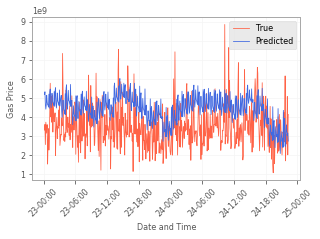

In [123]:
plt.rc('font', size=8)

fig_path = '/home/pjp18/Documents/marble_logs/'
begin = 300
end = 850
import matplotlib.dates as mdates
x1 = np.arange(900)

fig = plt.figure(figsize=(4.8041,3))
ax = plt.subplot()
ax.plot(x[begin:end], y_true[begin:end], color='tomato', label='True', linewidth=0.8)
ax.plot(x[begin:end], y_pred[begin:end], color='royalblue', label='Predicted', linewidth=0.8)
ax.set_ylabel('Gas Price', fontdict={'size':8})
ax.set_xlabel('Date and Time', fontdict={'size':8})

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H:00'))

ax.tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(loc='best', prop={'size': 8})
ax.set_facecolor('white')
ax.grid(color='whitesmoke')

fig.savefig(fig_path+'prediction_example.pdf', bbox_inches='tight', dpi=900)
plt.show()